## CAD-Recode Demonstration
In this demonstration, we load a point cloud and process it using a pre-trained CAD-Recode model, which generates Python CadQuery code. Finally, we interpret the code to create a CAD model, visualize it, and evaluate its quality metrics. This notebook works on both CPU and GPU.

### Define CAD-Recode model

In [4]:
import open3d
import trimesh
import skimage.io
import numpy as np
import cadquery as cq
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import torch
from torch import nn
from transformers import (
    AutoTokenizer, Qwen2ForCausalLM, Qwen2Model, PreTrainedModel)
from transformers.modeling_outputs import CausalLMOutputWithPast


class FourierPointEncoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        frequencies = 2.0 ** torch.arange(8, dtype=torch.float32)
        self.register_buffer('frequencies', frequencies, persistent=False)
        self.projection = nn.Linear(54, hidden_size)

    def forward(self, points):
        x = points[..., :3]
        x = (x.unsqueeze(-1) * self.frequencies).view(*x.shape[:-1], -1)
        x = torch.cat((points[..., :3], x.sin(), x.cos()), dim=-1)
        x = self.projection(torch.cat((x, points[..., 3:]), dim=-1))
        return x


class CADRecode(Qwen2ForCausalLM):
    def __init__(self, config):
        PreTrainedModel.__init__(self, config)
        self.model = Qwen2Model(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        
        torch.set_default_dtype(torch.float32)
        self.point_encoder = FourierPointEncoder(config.hidden_size)
        torch.set_default_dtype(torch.bfloat16)

    def forward(self,
                input_ids=None,
                attention_mask=None,
                point_cloud=None,
                position_ids=None,
                past_key_values=None,
                inputs_embeds=None,
                labels=None,
                use_cache=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=None,
                cache_position=None):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # concatenate point and text embeddings
        if past_key_values is None or past_key_values.get_seq_length() == 0:
            assert inputs_embeds is None
            inputs_embeds = self.model.embed_tokens(input_ids)
            point_embeds = self.point_encoder(point_cloud).bfloat16()
            inputs_embeds[attention_mask == -1] = point_embeds.reshape(-1, point_embeds.shape[2])
            attention_mask[attention_mask == -1] = 1
            input_ids = None
            position_ids = None

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            cache_position=cache_position)

        hidden_states = outputs[0]
        logits = self.lm_head(hidden_states)
        logits = logits.float()

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss()
            shift_logits = shift_logits.view(-1, self.config.vocab_size)
            shift_labels = shift_labels.view(-1)
            # Enable model parallelism
            shift_labels = shift_labels.to(shift_logits.device)
            loss = loss_fct(shift_logits, shift_labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return CausalLMOutputWithPast(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions)

    def prepare_inputs_for_generation(self, *args, **kwargs):
        model_inputs = super().prepare_inputs_for_generation(*args, **kwargs)
        model_inputs['point_cloud'] = kwargs['point_cloud']
        return model_inputs

### Load CAD-Recode checkpoint

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
attn_implementation = 'flash_attention_2' if torch.cuda.is_available() else None
tokenizer = AutoTokenizer.from_pretrained(
    'Qwen/Qwen2-1.5B',
    pad_token='<|im_end|>',
    padding_side='left')
model = CADRecode.from_pretrained(
    'filapro/cad-recode',
    torch_dtype='auto',
    attn_implementation=attn_implementation).eval().to(device)

### Load input point cloud
Load the mesh of one of the examples from the Fusion360 test set and sample 256 points from it. Then input mesh is normalized to fit within a cube of size 2, centered at the origin. Both the mesh and point cloud can be visualized interactively in this notebook using `open3d` or `trimesh`; however, for non-interactive environments, we render them as static images.

In [ ]:
!wget https://github.com/filaPro/cad-recode/releases/download/v1.0/49215_5368e45e_0000.stl

In [7]:
def mesh_to_point_cloud(mesh, n_points=256):
    vertices, faces = trimesh.sample.sample_surface(mesh, n_points)
    point_cloud = np.concatenate((
        np.asarray(vertices),
        mesh.face_normals[faces]
    ), axis=1)
    ids = np.lexsort((point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]))
    point_cloud = point_cloud[ids]
    return point_cloud


gt_mesh = trimesh.load_mesh('./49215_5368e45e_0000.stl')
gt_mesh.apply_translation(-(gt_mesh.bounds[0] + gt_mesh.bounds[1]) / 2.0)
gt_mesh.apply_scale(2.0 / max(gt_mesh.extents))
np.random.seed(42)
point_cloud = mesh_to_point_cloud(gt_mesh)

### Let's have a look at input point cloud
It looks like a table with four legs!

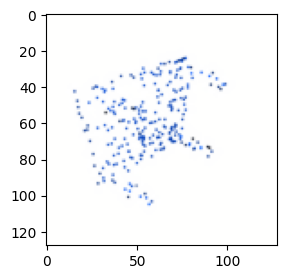

In [14]:
def render(geometry, image_size=128, camera_distance=-1.8, image_path='/tmp/tmp.png'):
    visualizer = open3d.visualization.Visualizer()
    visualizer.create_window(width=image_size * 4, height=image_size * 4)
    visualizer.add_geometry(geometry)

    lookat = np.array([0, 0, 0], dtype=np.float32)
    front = np.array([1, 1, 1], dtype=np.float32)
    up = np.array([0, 1, 0], dtype=np.float32)
    eye = lookat + front * camera_distance
    right = np.cross(up, front)
    right /= np.linalg.norm(right)
    true_up = np.cross(front, right)
    rotation_matrix = np.column_stack((right, true_up, front)).T
    extrinsic = np.eye(4)
    extrinsic[:3, :3] = rotation_matrix
    extrinsic[:3, 3] = -rotation_matrix @ eye

    view_control = visualizer.get_view_control()
    camera_params = view_control.convert_to_pinhole_camera_parameters()
    camera_params.extrinsic = extrinsic
    view_control.convert_from_pinhole_camera_parameters(camera_params)

    visualizer.poll_events()
    visualizer.update_renderer()
    visualizer.capture_screen_image(image_path)
    visualizer.destroy_window()

    image = skimage.io.imread(image_path)
    image = skimage.transform.resize(
        image,
        output_shape=(image_size, image_size),
        order=2,
        anti_aliasing=True,
        preserve_range=True).astype(np.uint8)
    return image

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(point_cloud[:, :3])
pcd.normals = open3d.utility.Vector3dVector(point_cloud[:, 3:])
pcd.paint_uniform_color(np.array([0, 80, 239]) / 255)
plt.figure(figsize=(3, 3))
_ = plt.imshow(render(pcd))

### Run CAD-Recode on the input point cloud

In [9]:
input_ids = [tokenizer.pad_token_id] * len(point_cloud) + [tokenizer('<|im_start|>')['input_ids'][0]]
attention_mask = [-1] * len(point_cloud) + [1]
with torch.no_grad():
    batch_ids = model.generate(
        input_ids=torch.tensor(input_ids).unsqueeze(0).to(model.device),
        attention_mask=torch.tensor(attention_mask).unsqueeze(0).to(model.device),
        point_cloud=torch.tensor(point_cloud.astype(np.float32)).unsqueeze(0).to(model.device),
        max_new_tokens=768,
        pad_token_id=tokenizer.pad_token_id)
py_string = tokenizer.batch_decode(batch_ids)[0]
begin = py_string.find('<|im_start|>') + 12
end = py_string.find('<|endoftext|>')
py_string = py_string[begin: end]
print(py_string)

import cadquery as cq
w0=cq.Workplane('XY',origin=(0,0,14))
r=w0.sketch().push([(-37,-33)]).circle(5).push([(-37,36)]).circle(5).push([(40,-34)]).circle(6).push([(39,36)]).circle(5).finalize().extrude(-38).union(w0.workplane(offset=10/2).box(100,84,10))


### Execute predicted python code to raise a CAD model
The predicted code might be invalid or could potentially cause memory leaks in CadQuery, as described in this [issue](https://github.com/CadQuery/cadquery/issues/1665).  Therefore, it is recommended to run the next cell in a separate process with a timeout of, for example, 3 seconds.:
```
process = Process(target=..., args=...)
process.start()
process.join(3)

if process.is_alive():
    process.terminate()
    process.join()
```
But in this demo safety is omitted.

In [10]:
exec(py_string, globals())
compound = globals()['r'].val()
vertices, faces = compound.tessellate(0.001, 0.1)
mesh = trimesh.Trimesh([(v.x, v.y, v.z) for v in vertices], faces)
mesh.export('/tmp/1.stl')
cq.exporters.export(compound, '/tmp/1.step')

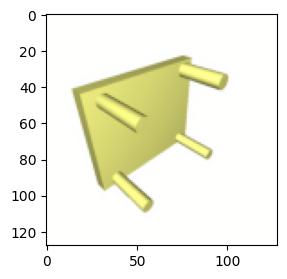

In [12]:
mesh = open3d.io.read_triangle_mesh('/tmp/1.stl')
mesh.vertices = open3d.utility.Vector3dVector(np.asarray(mesh.vertices) / 50.)
mesh.paint_uniform_color(np.array([255, 255, 136]) / 255)
mesh.compute_vertex_normals()
plt.figure(figsize=(3, 3))
_ = plt.imshow(render(mesh))

### Compute IoU and Chamfer distance metrics
The predicted model resembles a table, but let's calculate how closely it matches the ground truth mesh.

In [13]:
pred_mesh = trimesh.load_mesh('/tmp/1.stl')
pred_mesh.apply_transform(trimesh.transformations.scale_matrix(1 / 50 / 2))
pred_mesh.apply_transform(trimesh.transformations.translation_matrix([0.5, 0.5, 0.5]))
gt_mesh.apply_transform(trimesh.transformations.scale_matrix(1 / 2))
gt_mesh.apply_transform(trimesh.transformations.translation_matrix([0.5, 0.5, 0.5]))

n_points = 8192
gt_points, _ = trimesh.sample.sample_surface(gt_mesh, n_points)
pred_points, _ = trimesh.sample.sample_surface(pred_mesh, n_points)
gt_distance, _ = cKDTree(gt_points).query(pred_points, k=1)
pred_distance, _ = cKDTree(pred_points).query(gt_points, k=1)
cd = np.mean(np.square(gt_distance)) + np.mean(np.square(pred_distance))

intersection_volume = 0
for gt_mesh_i in gt_mesh.split():
    for pred_mesh_i in pred_mesh.split():
        intersection = gt_mesh_i.intersection(pred_mesh_i)
        volume = intersection.volume if intersection is not None else 0
        intersection_volume += volume

gt_volume = sum(m.volume for m in gt_mesh.split())
pred_volume = sum(m.volume for m in pred_mesh.split())
union_volume = gt_volume + pred_volume - intersection_volume
iou = intersection_volume / union_volume

print(f'CD: {cd * 1000:.3f}, IoU: {iou:.3f}')

CD: 0.232, IoU: 0.922
